## 이 파일의 목적

svm을 제외한 모델에서의 결과를 살펴보고 본다. 여기선 oversampling(smooth)와 minmax가 사용되었다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 9.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=13512f52d1496546a9b924b736e5252c87f639c33396ba170f7bfbea0d4f1768
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.1 MB/s eta 0:00:00


In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from ngboost import NGBClassifier, NGBRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [ ]:
# 이제 마지막 데이터셋! 더이상 바뀔 일 없음
path = '/content/drive/MyDrive/Colab Notebooks/model/4.27_lendingclub_individual_dataset.csv'
path2 = '/content/drive/MyDrive/Colab Notebooks/model/4.28_lendingclub_individual_dataset(test).csv'
df = pd.read_csv(path)
df2 = pd.read_csv(path2)
df

,emp_length_int,installment,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,mort_acc,num_rev_accts,open_acc,open_acc_6m,open_act_il,revol_bal,revol_util,loan_status,total_pymnt,funded_amnt_inv,earliest_cr_line_year,earliest_cr_line_month,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_Source Verified,verification_status_Verified
0,2,822.95,14.47,35000.0,30.0,154.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,6.0,1.0,1.0,24640.0,0.354,Current,16430.860000,35000.0,2002,12,2018,9,5,717.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10,680.82,24.99,23200.0,126.0,277.0,0.0,0.0,0.0,0.0,1.0,2.0,22.0,24.0,1.0,10.0,16909.0,0.559,Charged Off,8599.680000,23200.0,1993,5,2016,7,3,672.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,10,145.06,9.93,4500.0,127.0,265.0,0.0,0.0,0.0,1.0,1.0,0.0,27.0,22.0,2.0,0.0,6435.0,0.121,Current,4204.260000,4500.0,1995,11,2017,12,6,677.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,494.55,7.07,16000.0,134.0,400.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,18.0,1.0,2.0,3881.0,0.055,Charged Off,11804.280000,16000.0,1984,5,2017,10,7,822.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,5,146.10,10.42,4500.0,226.0,130.0,2.0,2.0,0.0,0.0,0.0,1.0,6.0,7.0,1.0,2.0,6824.0,0.494,Fully Paid,5134.174383,4500.0,1998,7,2017,5,6,702.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535624,7,133.78,19.99,3600.0,151.0,36.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,8.0,1.0,1.0,9711.0,0.908,Charged Off,469.070000,3600.0,2001,8,2014,3,3,667.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1535625,4,583.89,6.68,19000.0,125.0,216.0,0.0,0.0,0.0,0.0,0.0,5.0,16.0,15.0,1.0,4.0,11421.0,0.414,Fully Paid,20620.112719,18875.0,1997,3,2015,4,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1535626,9,329.65,14.33,9600.0,25.0,99.0,0.0,0.0,0

In [ ]:
# train 세트
not_deliq = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target.append(0)
    # 연체한 경우를 1
    else:
        target.append(1)
print(len(target))
print(len(df))

df['target'] = target

# test 세트
loan_stat2 = df2['loan_status']
target2 = []
for stat in loan_stat2:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target2.append(0)
    # 연체한 경우를 1
    else:
        target2.append(1)
print(len(target2))
print(len(df2))

df2['target'] = target2

1535629
1535629
1023521
1023521


In [ ]:
# current와 issued, in grace period를 제거
df = df[df['loan_status']!= 'Current']
df = df[df['loan_status']!= 'Issued']

df2 = df2[df2['loan_status']!= 'Current']
df2 = df2[df2['loan_status']!= 'Issued']

In [ ]:
df.drop(columns = 'loan_status', inplace = True)
df2.drop(columns = 'loan_status', inplace = True)

In [ ]:
column_types = df.dtypes

# float와 int 나누기
float_columns = []
int_columns = []
for column_name, dtype in column_types.items():
    if dtype == 'float':
        float_columns.append(column_name)
    elif dtype == 'int':
        int_columns.append(column_name)


# 데이터 유형에 따라 변환
df[float_columns] = df[float_columns].astype(np.float32)
df[int_columns] = df[int_columns].astype(np.int16)

df2[float_columns] = df2[float_columns].astype(np.float32)
df2[int_columns] = df2[int_columns].astype(np.int16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070411 entries, 1 to 1535627
Data columns (total 98 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   emp_length_int                       1070411 non-null  int16  
 1   installment                          1070411 non-null  float32
 2   int_rate                             1070411 non-null  float32
 3   loan_amnt                            1070411 non-null  float32
 4   mo_sin_old_il_acct                   1070411 non-null  float32
 5   mo_sin_old_rev_tl_op                 1070411 non-null  float32
 6   pub_rec                              1070411 non-null  float32
 7   pub_rec_bankruptcies                 1070411 non-null  float32
 8   chargeoff_within_12_mths             1070411 non-null  float32
 9   collections_12_mths_ex_med           1070411 non-null  float32
 10  inq_last_6mths                       1070411 non-null  float32
 11  mor

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713816 entries, 0 to 1023519
Data columns (total 98 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   emp_length_int                       713816 non-null  int16  
 1   installment                          713816 non-null  float32
 2   int_rate                             713816 non-null  float32
 3   loan_amnt                            713816 non-null  float32
 4   mo_sin_old_il_acct                   713816 non-null  float32
 5   mo_sin_old_rev_tl_op                 713816 non-null  float32
 6   pub_rec                              713816 non-null  float32
 7   pub_rec_bankruptcies                 713816 non-null  float32
 8   chargeoff_within_12_mths             713816 non-null  float32
 9   collections_12_mths_ex_med           713816 non-null  float32
 10  inq_last_6mths                       713816 non-null  float32
 11  mort_acc         

In [ ]:
# train에서 수익률을 확인하기위한 earing set도 20% 구분해서 저장
earning_test = df.sample(frac=0.2, random_state=42)

In [ ]:
# A, B등급은 우선 제외하고 학습시켜야함
#train
df_nonAB = df[(df['grade_numeric'] < 6)]

In [ ]:
# X와 y를 나누기 위해 list 생성
x_data = list(df.columns)
x_data.remove('target')
# 이 밑에는 사후변수!
x_data.remove('total_pymnt')
x_data.remove('funded_amnt_inv')
# 사후변수및 계산을 필요한 변수는 원본셋이 있으므로 패스

In [ ]:
x_data

['emp_length_int',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'mort_acc',
 'num_rev_accts',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'revol_bal',
 'revol_util',
 'earliest_cr_line_year',
 'earliest_cr_line_month',
 'issue_d_year',
 'issue_d_month',
 'grade_numeric',
 'fico_range_mean',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'term_ 60 months',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 '

## Standard scaler 적용

In [ ]:
processing = ['emp_length_int',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'mort_acc',
 'num_rev_accts',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'revol_bal',
 'revol_util']


In [ ]:
# standard로 scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_nonAB[processing])


# 새로운 DF에 스케일된 데이터를 저장
df_nonAB[processing] = scaled_data

In [ ]:
# scaler2 = StandardScaler()
# scaled_data2 = scaler2.fit_transform(df2[processing])
# df2[processing] = scaled_data2

In [ ]:
# 우선 랜덤하게 data_split하고 돌려봄 0.8:0.2
df_train, df_test = train_test_split(df_nonAB, test_size = .2, train_size = 0.8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [ ]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# Target

In [ ]:
# train셋을 oversampling
from imblearn.over_sampling import ADASYN
smt = ADASYN()
X_train, y_train = smt.fit_resample(df_train[x_data], df_train['target'])

In [ ]:
df_train.describe()

,emp_length_int,installment,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,mort_acc,num_rev_accts,open_acc,open_acc_6m,open_act_il,revol_bal,revol_util,total_pymnt,funded_amnt_inv,earliest_cr_line_year,earliest_cr_line_month,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_Source Verified,verification_status_Verified,target
count,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.00000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.00000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000,332931.000000
mean,0.000972,0.000911,0.002371,0.000208,0.001240,0.000101,-0.001432,-0.000698,0.000005,0.000231,0.001076,0.000332,0.000315,-0.000685,-0.000704,0.000453,0.001648,0.002472,15663.248047,15112.442383,1999.885108,6.744193,2015.440671,6.516524,4.313077,687.782166,0.455845,0.000033,0.00012,0.112188,0.431261,0.167407,0.612397,0.000213,0.060217,0.007299,0.020995,0.013624,0.009047,0.07376,0.000895,0.015370,0.008233,0.001367,0.381809,0.012931,0.007683,0.023566,0.140242,0.020752,0.014922,0.002250,0.002908,0.073135,0.032770,0.005376,0.000015,0.001535,0.037801,0.016778,0.008065,0.009849,0.011534,0.021278,0.024146,0.001670,0.026660,0.017349,0.015967,0.005836,0.002745,0.028775,0.001424,0.003211,0.004611,0.035788,0.005554,0.015352,0.084342,0.032694,0.009323,0.011603,0.034734,0.004403,0.012297,0.001967,0.016024,0.080029,0.007188,0.028138,0.002006,0.021665,0.012702,0.003731,0.002112,0.409607,0.359738,0.275829
std,1.000247,1.000523,1.001635,0.999789,0.999059,0.999408,0.996917,1.000831,0.988336,1.005713,1.001932,1.000353,1.000081,0.998608,0.998247,1.002610,0.997581,0.999075,11509.639648,914

In [ ]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

In [ ]:
prediction_times = []
training_times = []
scores = []

decision_tree = Train(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_test, y_test) # 결정트리
random_forest= Train(RandomForestClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트. Essemble 중 bagging에 대표적인 모델
extra_trees = Train(ExtraTreesClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트와 유사하지만, bagging은 아니다. 속도도 빠르고 bias도 varinace도 줄일 수 있다고 하지만... 최고라고 하기엔 흠?
xgboost = Train(XGBClassifier(n_estimators=100, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=100, max_depth=5, num_leaves = 70), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
# xgboost = Train(XGBClassifier(max_depth= 10, min_child_weight= 6, learning_rate = 0.1, n_estimators= 100, penalty= 'ridge', objective = 'binary:logistic', eval_metric = 'auc'), X_train, y_train, X_test, y_test)
# lgb = Train(LGBMClassifier(n_estimators=150, max_depth=20, num_leaves=150,learning_rate = 0.1, objective = 'binary', verbose=1), X_train, y_train, X_test, y_test)
# cat = Train(CatBoostClassifier(l2_leaf_reg= 5, n_estimators=200, learning_rate = 0.1, verbose=1, depth=6, loss_function='Logloss'), X_train, y_train, X_test, y_test)
ngb = Train(NGBClassifier(n_estimators=50, verbose=1, natural_gradient=3), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:05

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:22

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:09

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:02

Prediction time: 
Execution Time: 00:00:00
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 230385, number of negative: 241099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4521
[LightGBM] [Info] Number of data points in the train set: 471484, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488638 -> initscore=-0.045456
[LightGBM] [Info] Start training from score -0.045456
[LightGBM] [Warning

특이도(Specificity): 0.6992426974395961
민감도(Sensitivity) 또는 재현율(Recall): 0.3924738219895288
정확도(Accuracy): 0.6147670237977239
정밀도(Precision): 0.3315091210613599


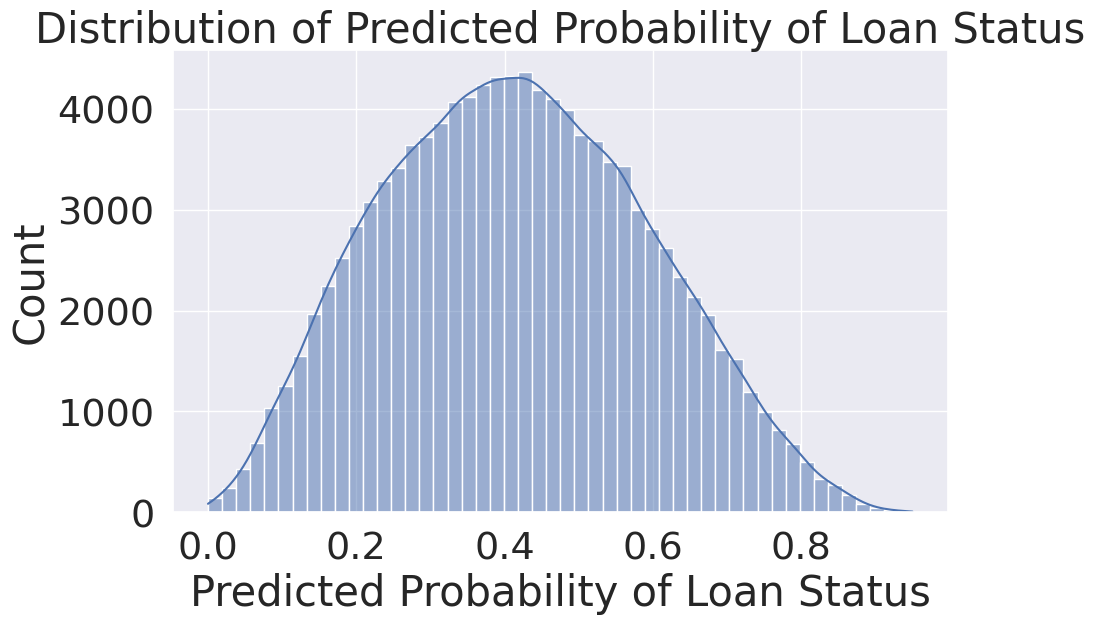

              precision    recall  f1-score   support

           0       0.75      0.70      0.72     80417
           1       0.33      0.39      0.36     30560

    accuracy                           0.61    110977
   macro avg       0.54      0.55      0.54    110977
weighted avg       0.64      0.61      0.62    110977



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


# 독립 변수와 종속 변수 분리
# X = df.drop('target', axis=1)  # 독립 변수
# y = df['target']  # 종속 변수

# # 데이터 정규화
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 훈련 데이터와 테스트 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # 오버샘플링 적용
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 다중 회귀 모델 훈련
model = LogisticRegression()
model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 특이도(Specificity), 민감도(재현율), 정확도, 정밀도 계산
conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
specificity = TN / (TN + FP)
recall = sensitivity = TP / (TP + FN)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("특이도(Specificity):", specificity)
print("민감도(Sensitivity) 또는 재현율(Recall):", recall)
print("정확도(Accuracy):", accuracy)
print("정밀도(Precision):", precision)

# 예측 결과의 분포 시각화
y_pred_proba = model.predict_proba(X_test)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.xlabel('Predicted Probability of Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probability of Loan Status')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))

In [ ]:
models = [
    ('DecisionTree', decision_tree),
    ('RandomForest', random_forest),
    ('ExtraTrees', extra_trees),
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('NgBoost', ngb),
    ('Logistic', model)
]

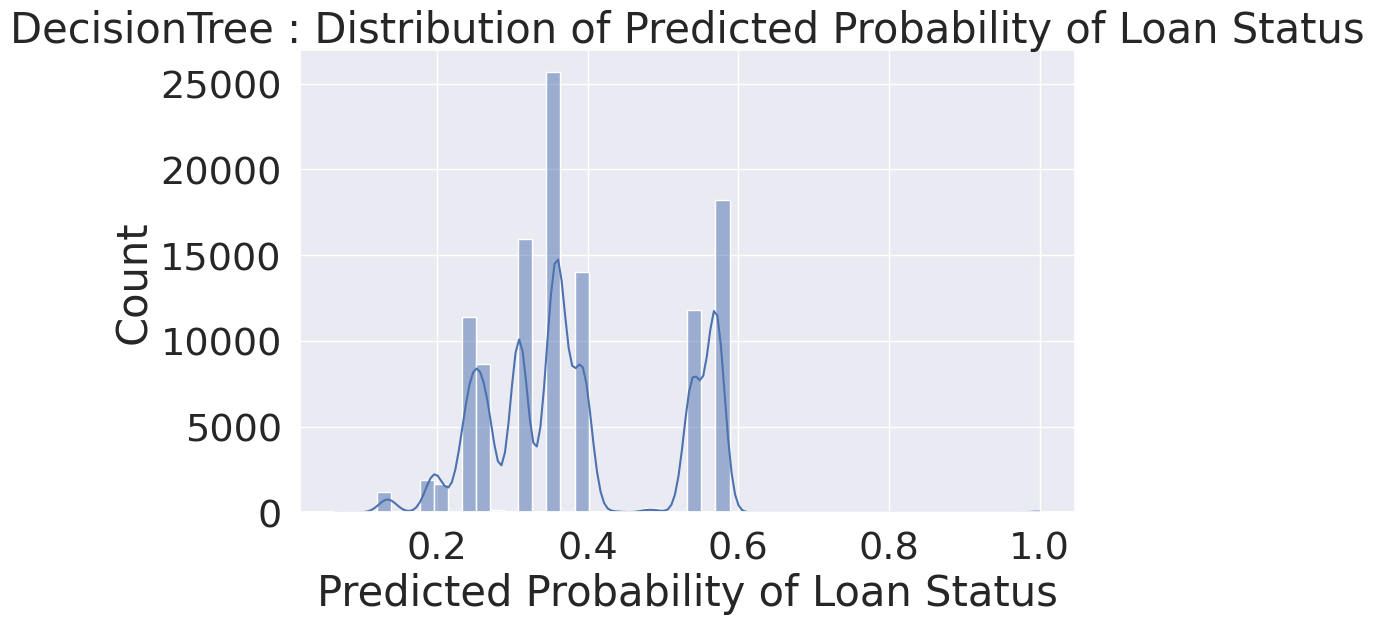

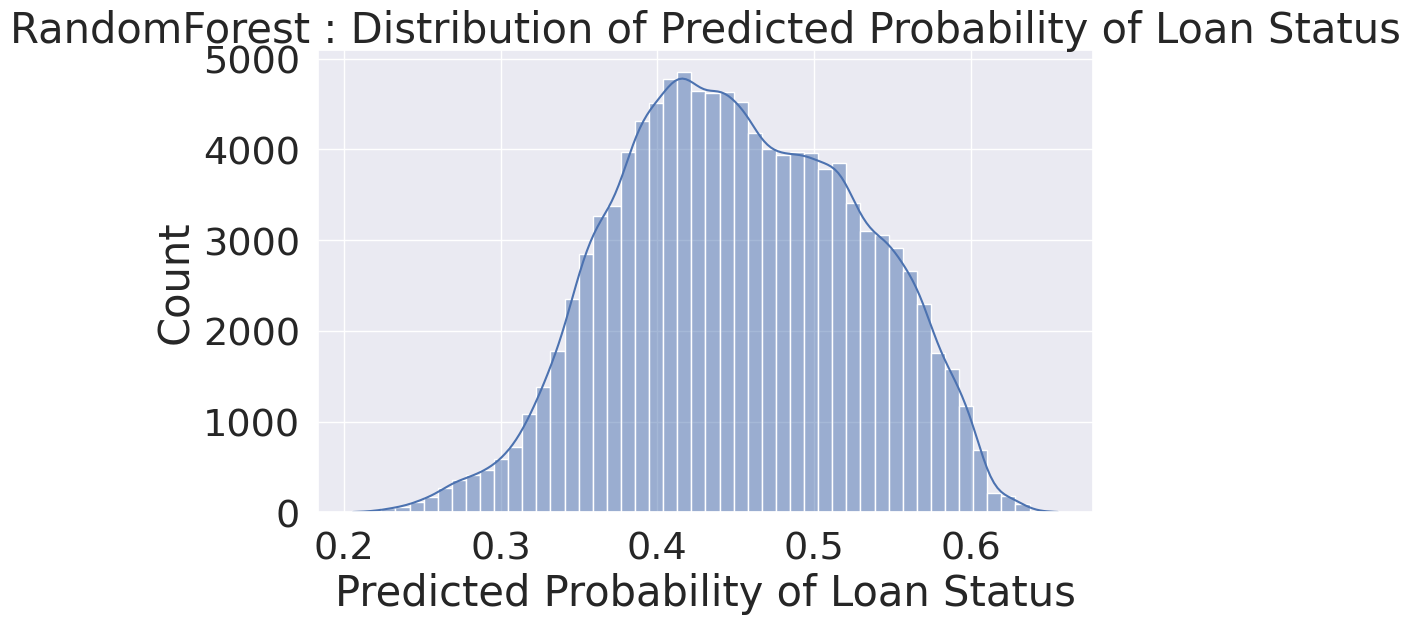

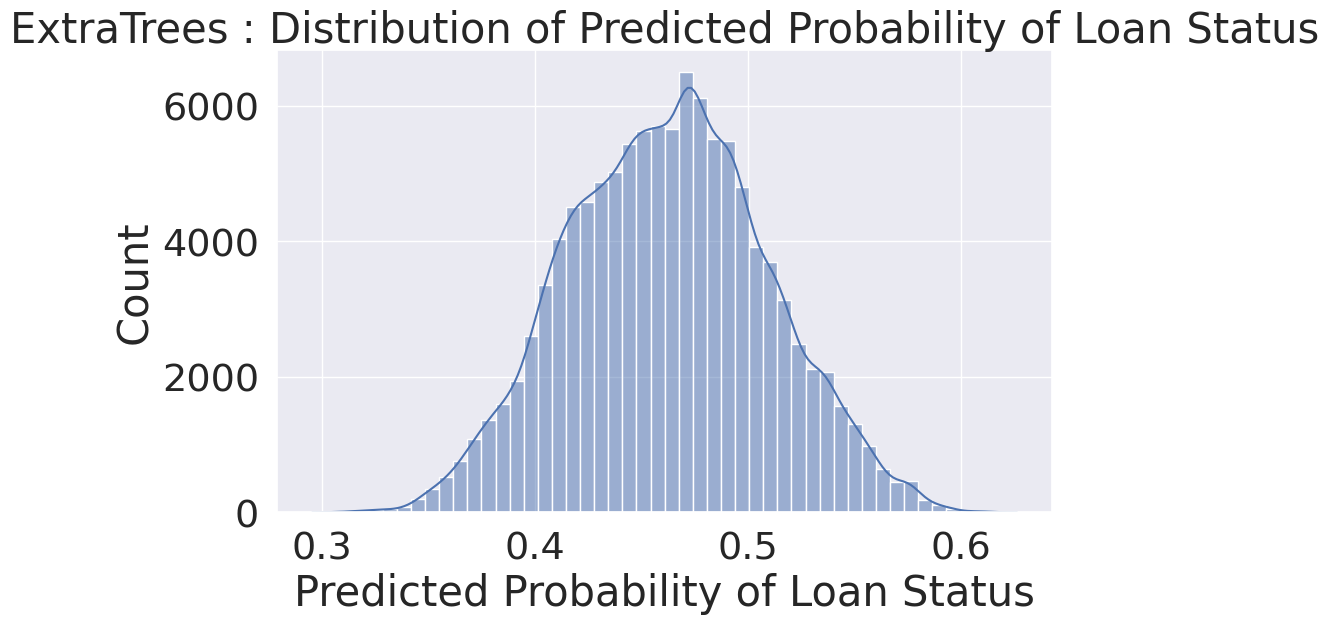

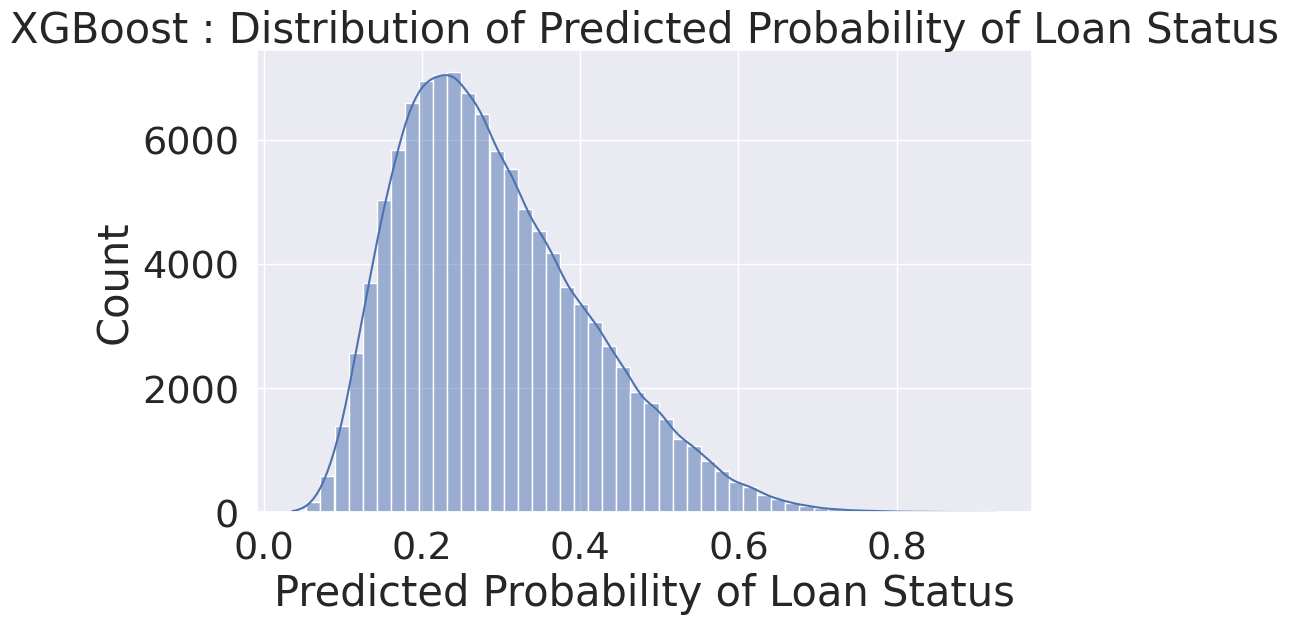

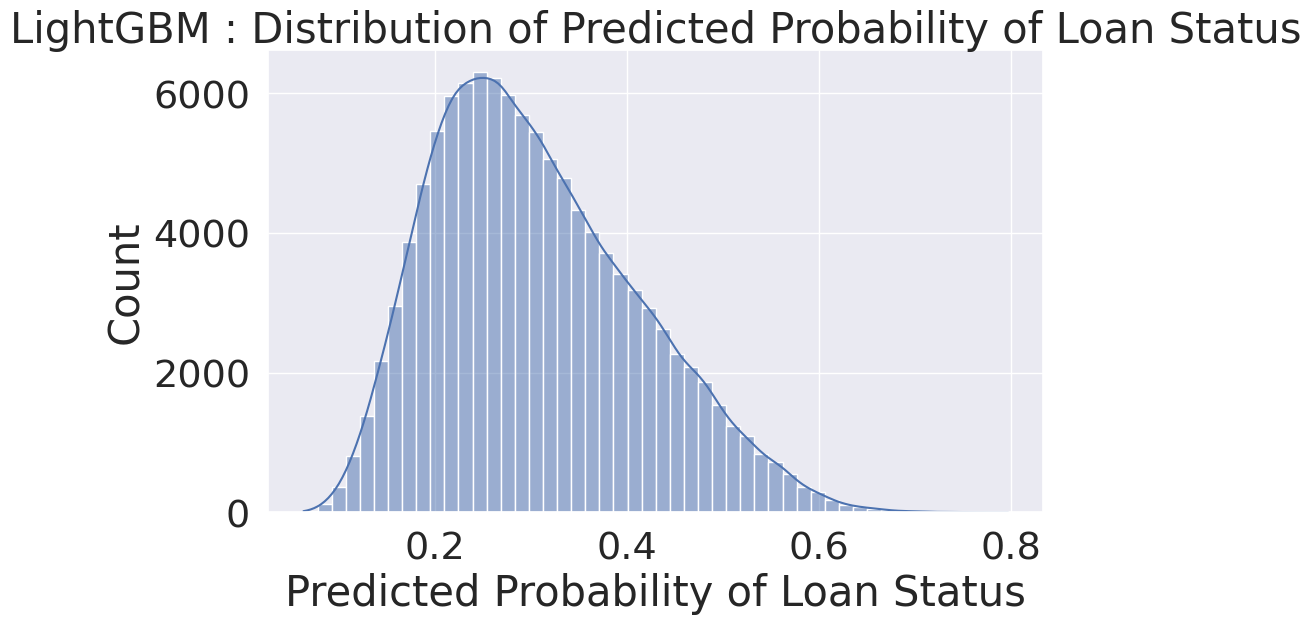

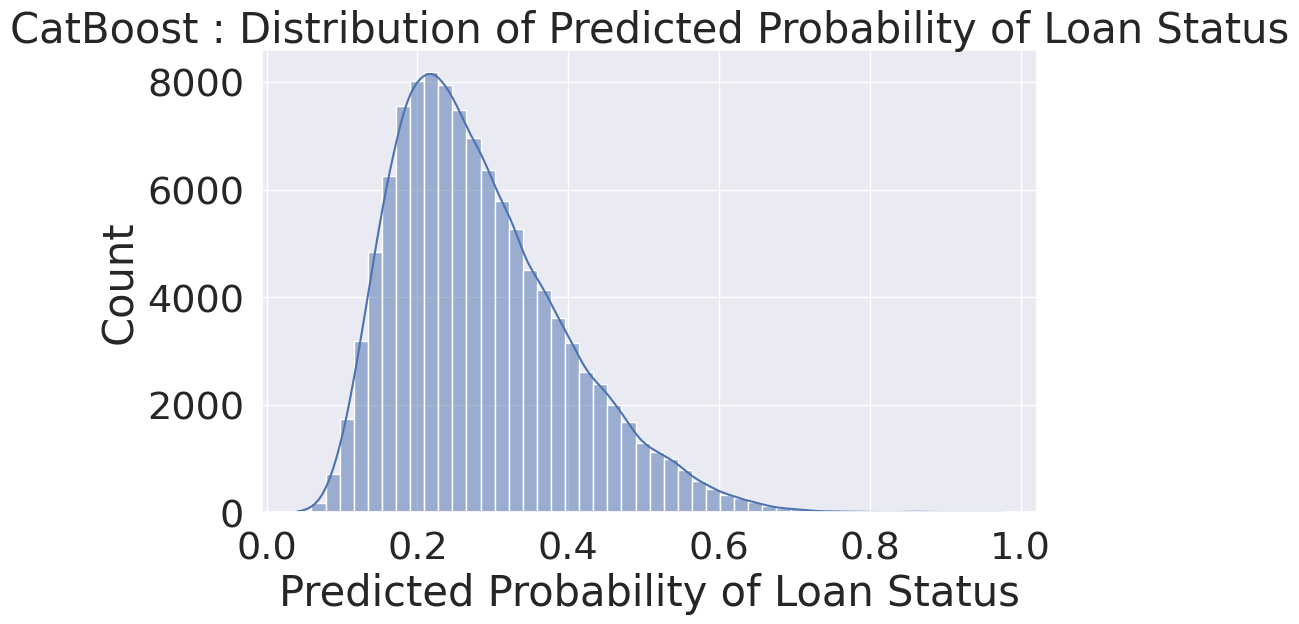

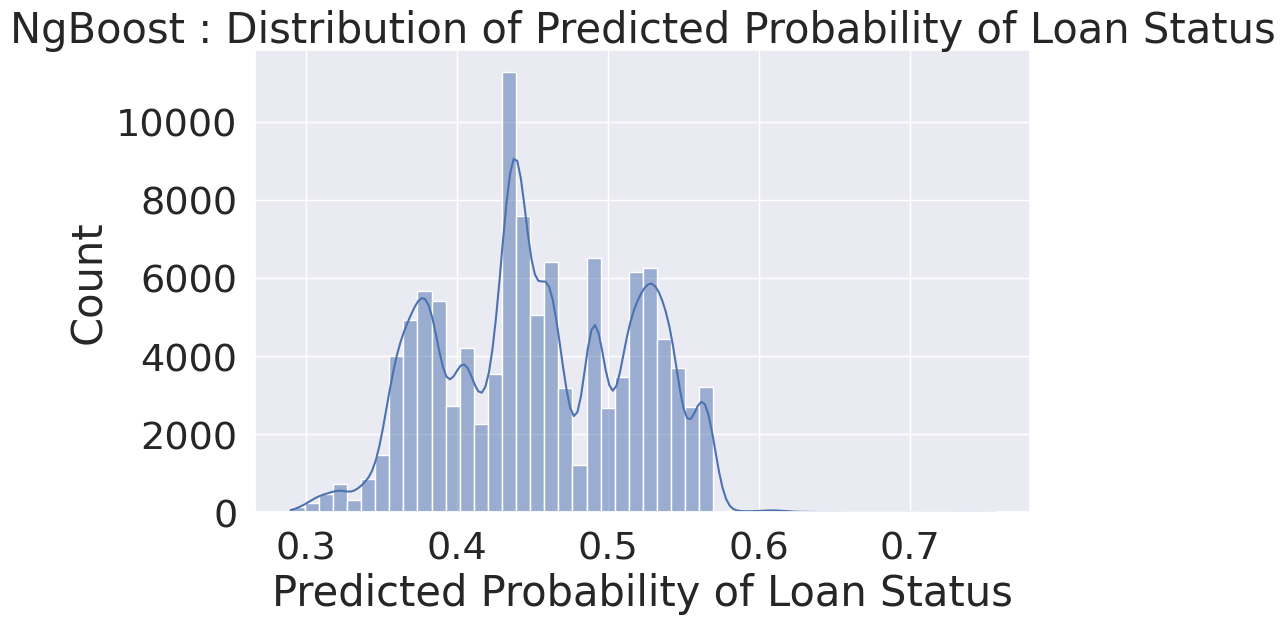

In [ ]:
# 예측 결과의 분포 시각화 (logsitc 제외)
for name, model in models[:-1]:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_proba, bins=50, kde=True)
    plt.xlabel('Predicted Probability of Loan Status')
    plt.ylabel('Count')
    plt.title(f'{name} : Distribution of Predicted Probability of Loan Status')
    plt.show()

In [ ]:
# score에 있는 점수를 소수점 5째자리까지 반올림
scores.append(accuracy)
for i in range(len(scores)):
    scores[i] = round(scores[i],5)
scores

[0.65496, 0.65104, 0.65907, 0.72656, 0.72581, 0.7293, 0.65498, 0.61477]

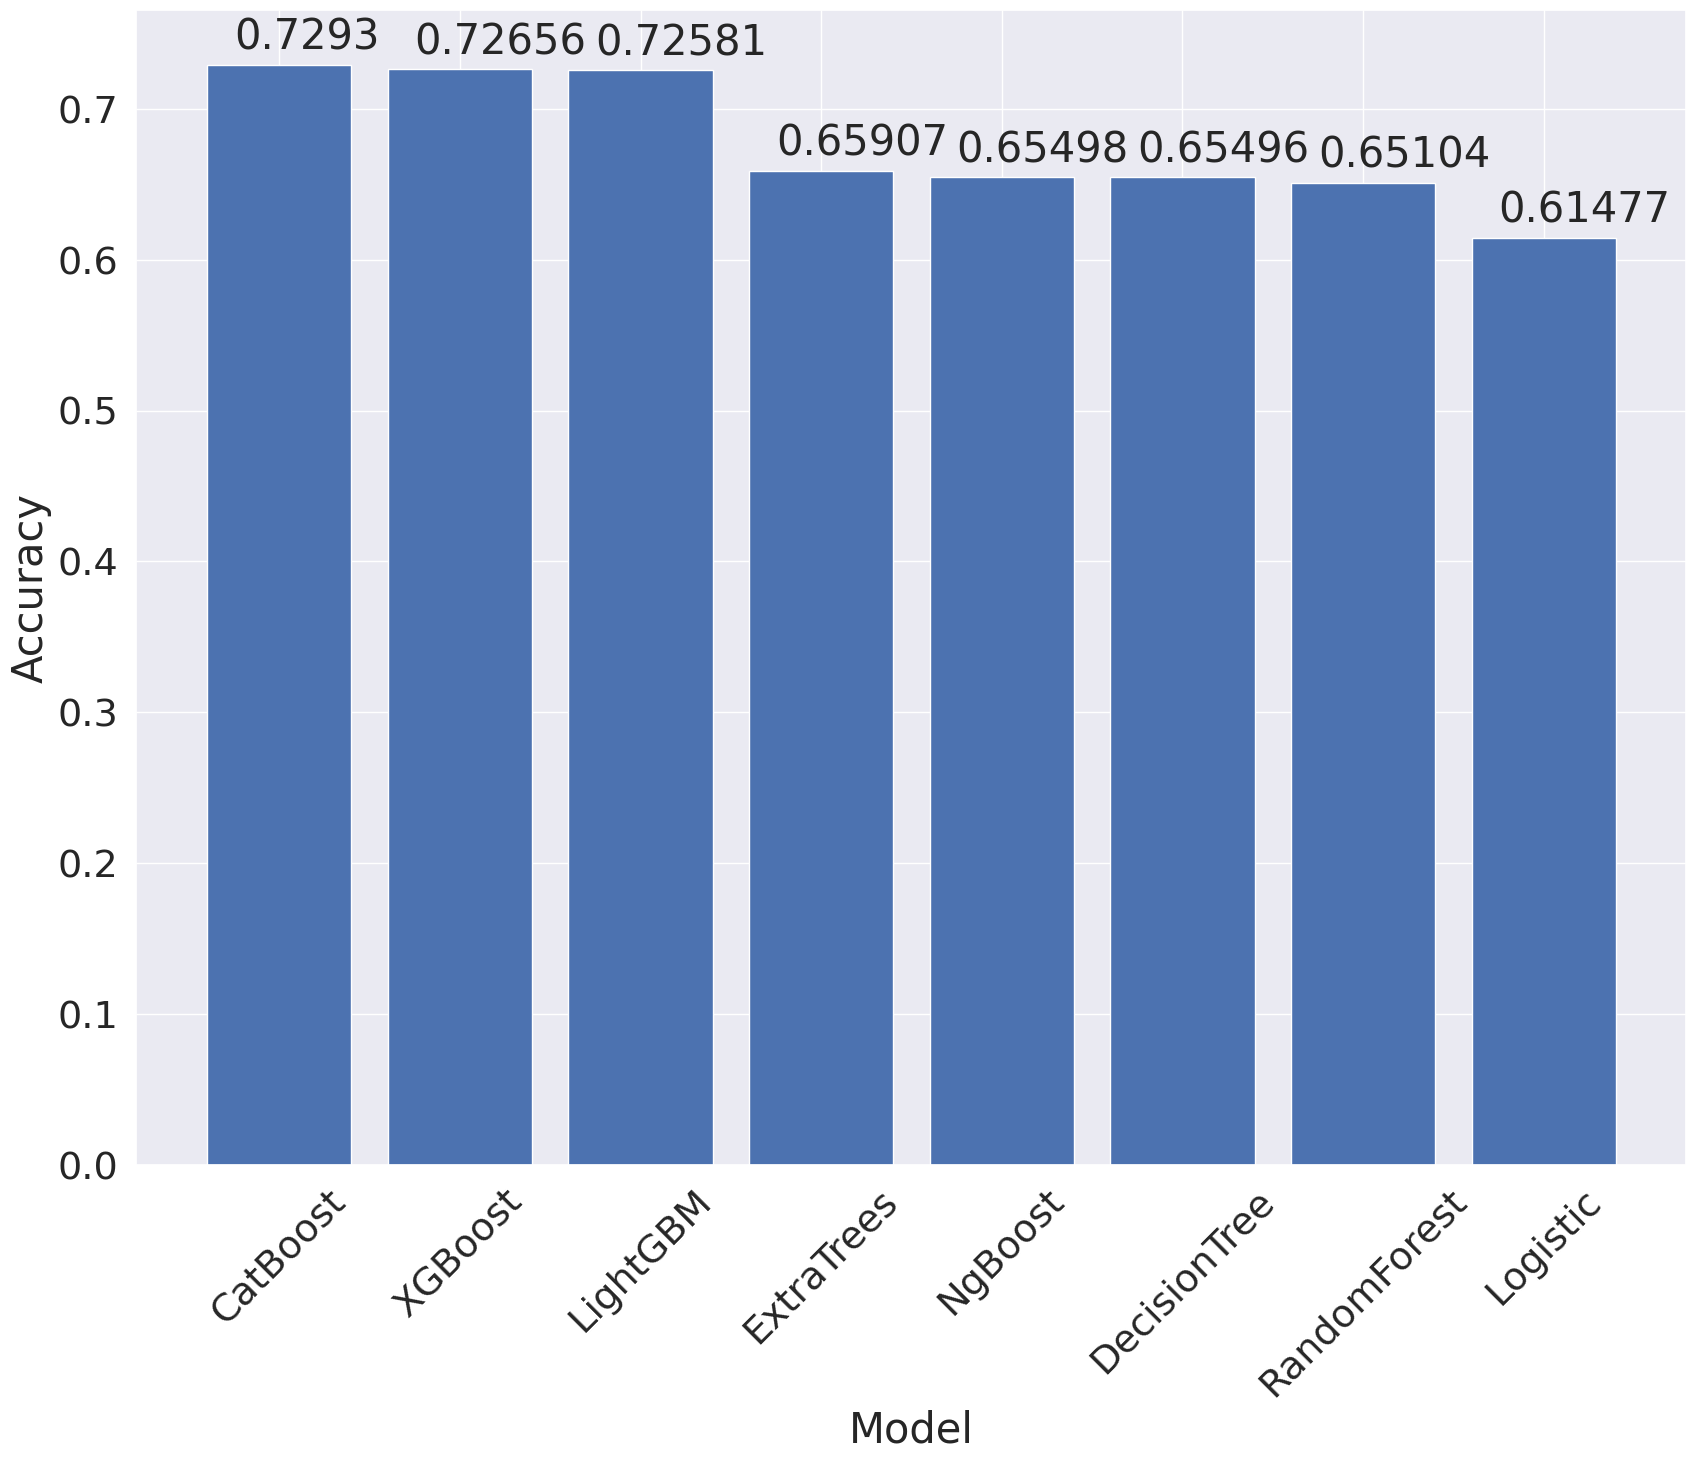

In [ ]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for DecisionTree
[[61513 18904]
 [19388 11172]]

Confusion Matrix for RandomForest
[[60375 20042]
 [18684 11876]]

Confusion Matrix for ExtraTrees
[[65039 15378]
 [22457  8103]]

Confusion Matrix for XGBoost
[[76983  3434]
 [26911  3649]]

Confusion Matrix for LightGBM
[[77498  2919]
 [27510  3050]]

Confusion Matrix for CatBoost
[[77872  2545]
 [27497  3063]]

Confusion Matrix for NgBoost
[[61299 19118]
 [19171 11389]]

Confusion Matrix for Logistic
[[56231 24186]
 [18566 11994]]



In [ ]:
from sklearn.metrics import classification_report
for name, model in models:
    print(name)
    print(classification_report(y_test, model.predict(X_test)))
    print('----------------------------------------------------------------------------')

DecisionTree
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     80417
           1       0.37      0.37      0.37     30560

    accuracy                           0.65    110977
   macro avg       0.57      0.57      0.57    110977
weighted avg       0.65      0.65      0.65    110977

----------------------------------------------------------------------------
RandomForest
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     80417
           1       0.37      0.39      0.38     30560

    accuracy                           0.65    110977
   macro avg       0.57      0.57      0.57    110977
weighted avg       0.66      0.65      0.65    110977

----------------------------------------------------------------------------
ExtraTrees
              precision    recall  f1-score   support

           0       0.74      0.81      0.77     80417
           1       0.35      0.27      0.30   

In [ ]:
for name, model in models:
    print(name)
    print(classification_report(df_test['target'], model.predict(df_test[x_data])))
    print('----------------------------------------------------------------------------')

DecisionTree
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     80765
           1       0.37      0.37      0.37     30212

    accuracy                           0.65    110977
   macro avg       0.56      0.56      0.56    110977
weighted avg       0.65      0.65      0.65    110977

----------------------------------------------------------------------------
RandomForest
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     80765
           1       0.37      0.39      0.38     30212

    accuracy                           0.65    110977
   macro avg       0.57      0.57      0.57    110977
weighted avg       0.66      0.65      0.65    110977

----------------------------------------------------------------------------
ExtraTrees
              precision    recall  f1-score   support

           0       0.75      0.81      0.78     80765
           1       0.34      0.27      0.30   

                     feature  importance
27        home_ownership_OWN    0.230153
32  purpose_home_improvement    0.083656
10            inq_last_6mths    0.069441
14               open_acc_6m    0.064332
37             purpose_other    0.051865
28       home_ownership_RENT    0.041736
22             grade_numeric    0.037081
15               open_act_il    0.034863
24   home_ownership_MORTGAGE    0.032743
11                  mort_acc    0.030754


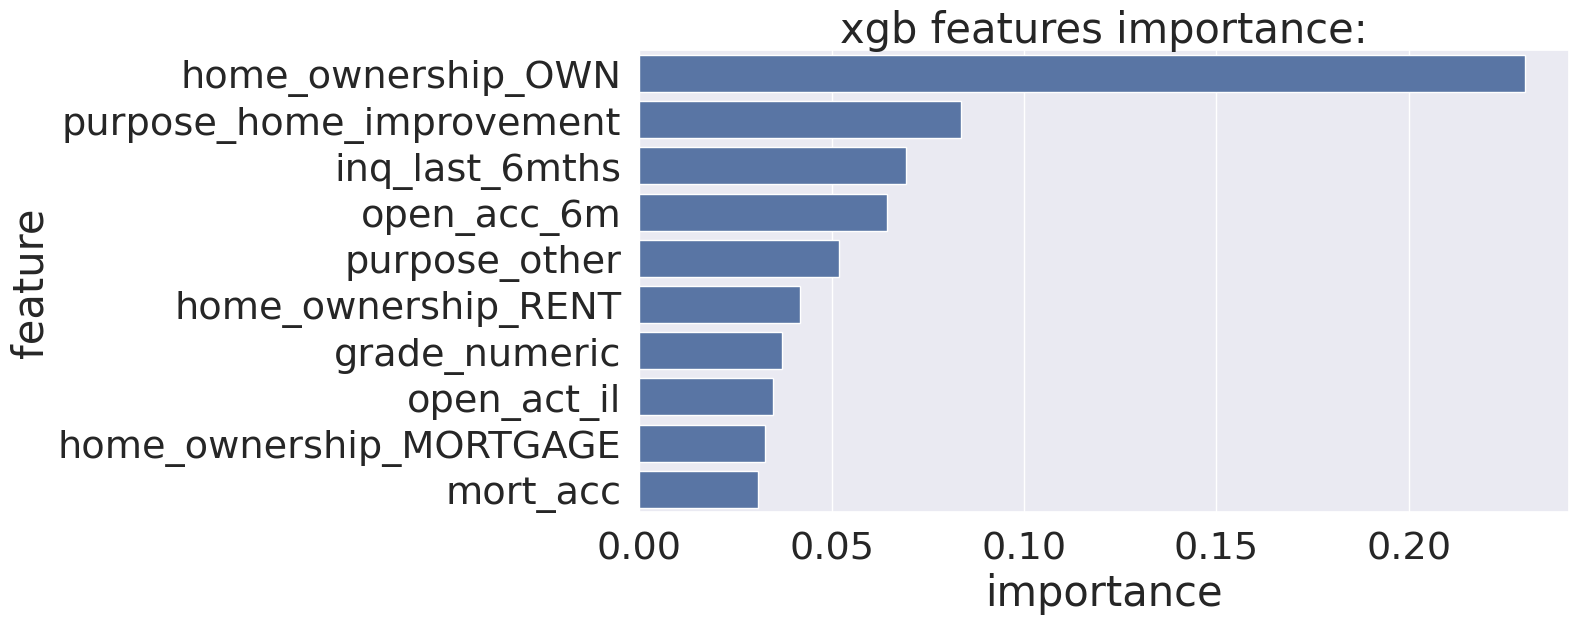

In [ ]:
feature_importances(X_train, xgboost, "xgb")

            feature  importance
20     issue_d_year         269
15      open_act_il         210
3         loan_amnt         187
11         mort_acc         161
14      open_acc_6m         156
2          int_rate         155
10   inq_last_6mths         154
0    emp_length_int         133
22    grade_numeric         126
42  term_ 60 months         124


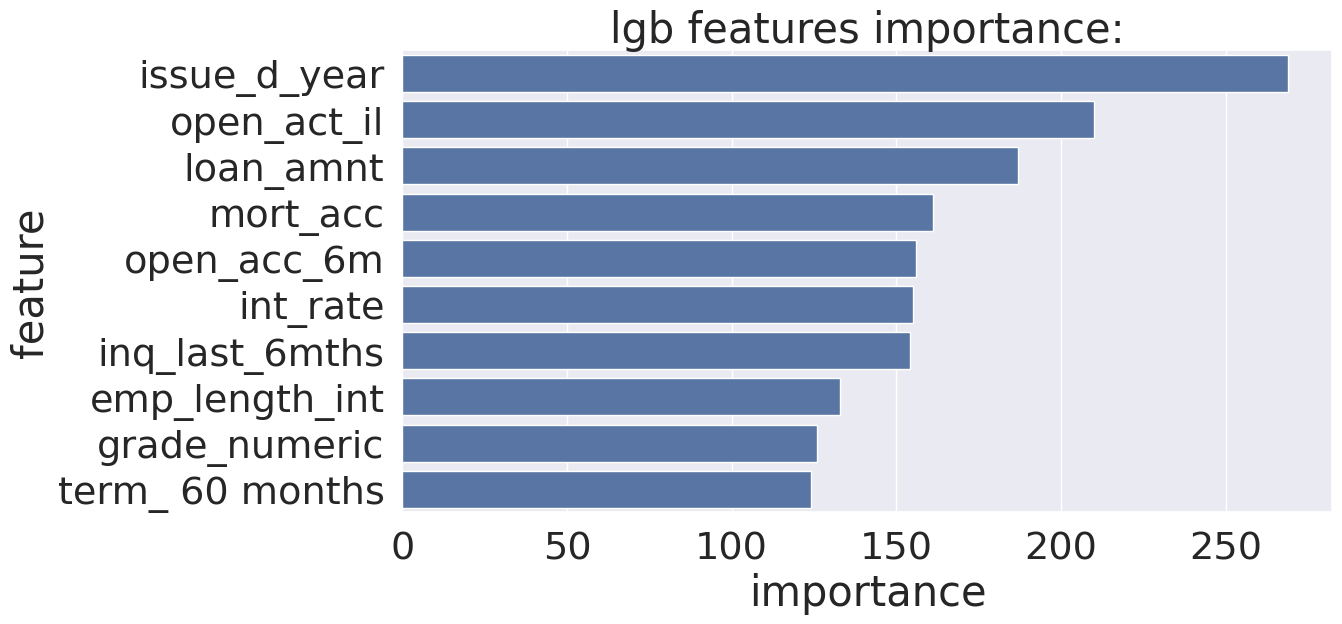

In [ ]:
feature_importances(X_train, lgb, 'lgb')

                    feature  importance
14              open_acc_6m   26.670130
11                 mort_acc   18.574998
10           inq_last_6mths   16.697565
15              open_act_il   16.059125
0            emp_length_int    8.734411
24  home_ownership_MORTGAGE    3.893924
28      home_ownership_RENT    3.528930
13                 open_acc    2.499242
27       home_ownership_OWN    2.270911
22            grade_numeric    0.281833


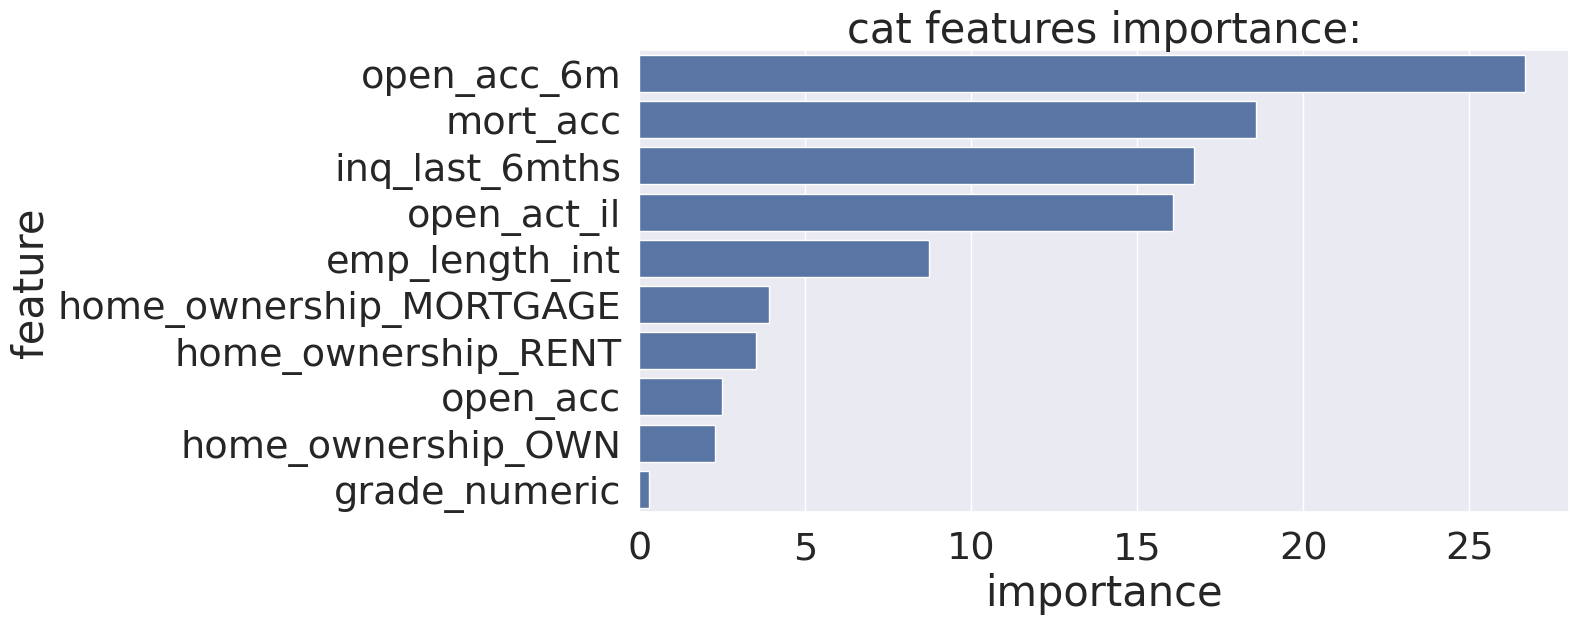

In [ ]:
feature_importances(X_train, cat, 'cat')

## 수익률 계산
1. 우수작 사례 - 개별로 계산

여기서 threshold 적용X 그냥 기본값만 생각해서 비교.

우수작부터(earning rate부터진행)

## earning test

In [ ]:
df_cal = pd.DataFrame()

lst = ['target', 'loan_amnt', 'total_pymnt', 'installment', 'grade_numeric']

df_cal[lst] = earning_test[lst]

In [ ]:
term = earning_test['term_ 60 months']
temp = []

for x in term:
    if x == 1:
        temp.append(60)
    else:
        temp.append(36)
df_cal['term'] = temp

In [ ]:
df_cal

,target,loan_amnt,total_pymnt,installment,grade_numeric,term
948327,0,35000.0,40992.828125,1246.280029,5,36
1499823,0,6000.0,6382.945801,185.839996,7,36
697662,0,11200.0,11933.700195,382.739990,5,36
94380,0,15000.0,16936.236328,519.909973,5,36
1082435,0,20775.0,24915.949219,511.299988,4,60
...,...,...,...,...,...,...
886196,0,8000.0,9476.968750,263.390015,6,36
217451,0,10000.0,11818.034180,329.910004,6,36
1424338,0,10000.0,11783.737305,327.339996,6,36
406004,0,23700.0,31255.949219,868.630005,4,36


In [ ]:
# standard로 scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(earning_test[processing])


# 새로운 DF에 스케일된 데이터를 저장
earning_test[processing] = scaled_data

In [ ]:
models

[('DecisionTree', DecisionTreeClassifier(max_depth=5)),
 ('RandomForest', RandomForestClassifier(max_depth=5, n_estimators=50)),
 ('ExtraTrees', ExtraTreesClassifier(max_depth=5, n_estimators=50)),
 ('XGBoost',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...)),
 ('LightGBM

In [ ]:
# 필요한 데이터로 pred만들기
for name, model in models:
    df_cal[name] = model.predict(earning_test[x_data])
    df_cal.loc[df_cal['grade_numeric'] > 5, name] = 1

In [ ]:
df_cal

,target,loan_amnt,total_pymnt,installment,grade_numeric,term,DecisionTree,RandomForest,ExtraTrees,XGBoost,LightGBM,CatBoost,NgBoost,Logistic
948327,0,35000.0,40992.828125,1246.280029,5,36,1,1,0,1,1,1,1,0
1499823,0,6000.0,6382.945801,185.839996,7,36,1,1,1,1,1,1,1,1
697662,0,11200.0,11933.700195,382.739990,5,36,0,0,0,1,1,1,0,0
94380,0,15000.0,16936.236328,519.909973,5,36,0,1,0,1,1,1,0,0
1082435,0,20775.0,24915.949219,511.299988,4,60,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886196,0,8000.0,9476.968750,263.390015,6,36,1,1,1,1,1,1,1,1
217451,0,10000.0,11818.034180,329.910004,6,36,1,1,1,1,1,1,1,1
1424338,0,10000.0,11783.737305,327.339996,6,36,1,1,1,1,1,1,1,1
406004,0,23700.0,31255.949219,868.630005,4,36,1,1,0,1,1,1,1,0


In [ ]:
for name, model in models:
    # 실제로 부도인데 못 맞춘 경우
    A = df_cal[(df_cal['target'] == 1) & (df_cal[name] == 0)]['installment'] * (df_cal[(df_cal['target'] == 1) & (df_cal[name] == 0)]['term']) - df_cal[(df_cal['target'] == 1) & (df_cal[name] == 0)]['total_pymnt']
    # 실제로 부도가 아닌데 부도라고 한 경우
    B = df_cal[(df_cal['target'] == 0) & (df_cal[name] == 1)]['total_pymnt'] - df_cal[(df_cal['target'] == 0) & (df_cal[name] == 1)]['loan_amnt']

    total_loss = A.sum() + B.sum()
    print(name,'총 손실:', total_loss)

DecisionTree 총 손실: 456424591.80792236
RandomForest 총 손실: 422112751.0635948
ExtraTrees 총 손실: 499629698.421093
XGBoost 총 손실: 416088876.1607208
LightGBM 총 손실: 416054292.4403076
CatBoost 총 손실: 416382258.6614685
NgBoost 총 손실: 436708569.0570183
Logistic 총 손실: 481754543.7670975


## Test set

In [ ]:
df_cal2 = pd.DataFrame()

df_cal2[lst] = df2[lst]

In [ ]:
term = df2['term_ 60 months']
temp = []

for x in term:
    if x == 1:
        temp.append(60)
    else:
        temp.append(36)
df_cal2['term'] = temp

In [ ]:
# standard로 scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df2[processing])


# 새로운 DF에 스케일된 데이터를 저장
df2[processing] = scaled_data

In [ ]:
# 필요한 데이터로 pred만들기
for name, model in models:
    df_cal2[name] = model.predict(df2[x_data])
    df_cal2.loc[df_cal2['grade_numeric'] > 5, name] = 1

In [ ]:
df_cal2

,target,loan_amnt,total_pymnt,installment,grade_numeric,term,DecisionTree,RandomForest,ExtraTrees,XGBoost,LightGBM,CatBoost,NgBoost,Logistic
0,0,20000.0,21913.552734,608.719971,7,36,1,1,1,1,1,1,1,1
2,1,12000.0,6001.910156,283.220001,5,60,0,1,0,1,1,1,0,0
5,0,15000.0,16141.454102,451.730011,7,36,1,1,1,1,1,1,1,1
6,0,20000.0,21944.810547,674.369995,6,36,1,1,1,1,1,1,1,1
9,0,11150.0,13436.829102,381.029999,5,36,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023515,0,6000.0,6619.847168,185.240005,7,36,1,1,1,1,1,1,1,1
1023516,0,6000.0,7187.030762,201.559998,5,36,0,0,0,1,1,1,0,0
1023517,0,9600.0,11058.805664,307.480011,6,36,1,1,1,1,1,1,1,1
1023518,1,8400.0,3654.919922,333.320007,3,36,1,1,1,1,1,1,1,1


In [ ]:
for name, model in models:
    # 실제로 부도인데 못 맞춘 경우
    A = df_cal2[(df_cal2['target'] == 1) & (df_cal2[name] == 0)]['installment'] * (df_cal2[(df_cal2['target'] == 1) & (df_cal2[name] == 0)]['term']) - df_cal2[(df_cal2['target'] == 1) & (df_cal2[name] == 0)]['total_pymnt']
    # 실제로 부도가 아닌데 부도라고 한 경우
    B = df_cal2[(df_cal2['target'] == 0) & (df_cal2[name] == 1)]['total_pymnt'] - df_cal2[(df_cal2['target'] == 0) & (df_cal2[name] == 1)]['loan_amnt']

    total_loss = A.sum() + B.sum()
    print(name,'총 손실:', total_loss)

DecisionTree 총 손실: 1527448904.9780598
RandomForest 총 손실: 1416938902.2026272
ExtraTrees 총 손실: 1671200470.878992
XGBoost 총 손실: 1394645407.4857635
LightGBM 총 손실: 1394456620.6741028
CatBoost 총 손실: 1394902318.5579681
NgBoost 총 손실: 1460075808.1722546
Logistic 총 손실: 1606101779.3646755
